In [7]:
import numpy
import sys
sys.path.append('../')
from dengo_freefall import *

/home/kwoksun2/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


 using cli
 using CLI for selections


In [15]:
Tdim = 16
Ddim = 16

temp_list = numpy.logspace(2,3.7,Tdim)
den_list  = numpy.logspace(0,14,Ddim)

temp_2d, den_2d = numpy.meshgrid(temp_list,den_list)
den_temp_pair2d = numpy.dstack( (temp_2d,den_2d)  )

den_temp_pair2d = ( numpy.reshape(den_temp_pair2d, (Tdim*Ddim,2) )  )

In [71]:
14 / (3.7-2)

8.235294117647058

In [4]:
def Init_values(temperature, density, n_species = 9, cooling=True, size=10):
    """ Create a initial value dictionary,
        for a given temperature, density, number of species
    Args:
        temperature -- in Kelvin
        density     -- in amu / cm**3
        n_species   -- number of species (6/9)
        cooling

    Returns:
        init_values: initial value dictionary with
                     self-consistent energy/ electron density
        primordial : chemical_network classes

    """

    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()
    primordial.threebody = 4

    if n_species == 9:
        for i in range(22):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass
    else:
        for i in range(6):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass

    # the temperature array required to interpolates the rates
    primordial.init_temperature((1e0, 1e5))

    tiny = 1.0e-20

    # init_array are is in fractional abundances
    init_values = dict()
    density = numpy.array([density])*numpy.ones((size))
    if n_species == 6:
        # 6-species model
        init_values["He_1"]    = density * (1.0 - 0.76)
        init_values["He_2"]    = np.array([tiny])
        init_values["He_3"]    = np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = np.array([tiny]) 
    else:
        # 9-species model
        init_values["He_1"]    = density * (1.0 - 0.76) 
        init_values["He_2"]    = density *np.array([tiny])
        init_values["He_3"]    = density *np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = density *np.array([tiny])

        init_values["H_m0"]    = density *np.array([tiny])
        init_values["H2_1"]    = density *np.array([tiny])
        init_values["H2_2"]    = density *np.array([tiny])

    # now everything in mass density
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)

    num_den = {}
    for sp in primordial.required_species:
        try:
            num_den[sp.name] = init_values[sp.name]/ sp.weight
        except:
            pass

    # set up initial temperatures values used to define ge
    init_values['T'] = numpy.array([temperature])*numpy.ones((size))
    ge_array = numpy.ones((size))
    init_values['ge'] = ge_array
    
    # calculate gammaH2
    
    for i in range(size):
        
        temperature = init_values['T'][i]

        rs = primordial.required_species
        H2_1_sp = list(rs)[0]
        gammaH2 = primordial.species_gamma(H2_1_sp,name=False, temp=True).subs({'T':temperature})

        new_num_den = {}
        for ele in num_den.keys():
            new_num_den[ele] = num_den[ele][i]
        
        gamma_factor = primordial.gamma_factor().subs(new_num_den).subs({'gammaH2': gammaH2 , 'gamma': 5./3.,'T': temperature })

        ge  = ((temperature *  kboltz) *gamma_factor
                             / (init_values['density'][i] * mh  ))

        
        T = init_values['density']*ge*mh / kboltz / gamma_factor
        init_values['ge'][i] = numpy.float64(ge)

    if cooling:
        for cooling_action in cooling_registry:
            k = cooling_registry[cooling_action]
            if (k.species).issubset( primordial.required_species ):
                if k.name != "cie_cooling":                    
                    print("adding cooling: {}".format(k.name) )
                    primordial.add_cooling(cooling_action)
    return init_values, primordial

In [4]:
den_temp_pair2d

array([[1.00000000e+02, 1.00000000e+00],
       [1.29817528e+02, 1.00000000e+00],
       [1.68525904e+02, 1.00000000e+00],
       [2.18776162e+02, 1.00000000e+00],
       [2.84009805e+02, 1.00000000e+00],
       [3.68694506e+02, 1.00000000e+00],
       [4.78630092e+02, 1.00000000e+00],
       [6.21345752e+02, 1.00000000e+00],
       [8.06615692e+02, 1.00000000e+00],
       [1.04712855e+03, 1.00000000e+00],
       [1.35935639e+03, 1.00000000e+00],
       [1.76468286e+03, 1.00000000e+00],
       [2.29086765e+03, 1.00000000e+00],
       [2.97394775e+03, 1.00000000e+00],
       [3.86070543e+03, 1.00000000e+00],
       [5.01187234e+03, 1.00000000e+00],
       [1.00000000e+02, 8.57695899e+00],
       [1.29817528e+02, 8.57695899e+00],
       [1.68525904e+02, 8.57695899e+00],
       [2.18776162e+02, 8.57695899e+00],
       [2.84009805e+02, 8.57695899e+00],
       [3.68694506e+02, 8.57695899e+00],
       [4.78630092e+02, 8.57695899e+00],
       [6.21345752e+02, 8.57695899e+00],
       [8.066156

In [5]:
runtime = []
all_result = []
d = 1
for temperature, density in den_temp_pair2d:
    init, _ = Init_values(temperature, density, n_species = 9, cooling=True, size=1)

    # os.system('rm test_cvdls_initial_conditions.h5')
    os.system('rm {}.h5'.format(d))
    f = h5py.File('{}.h5'.format(d))
    
    for k,v in init.items():
        f.create_dataset( k, data=v*numpy.ones(( 1024 )) )
    f.close()

    t_ff = ((u.G * u.mass_hydrogen * density * u.cm**-3)**-0.5).in_units('s')
    
    d += 1

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [32]:
import h5py
f = h5py.File('test_cvdls_initial_conditions.h5')
print(f['T'].value)
print(f['ge'].value)

[5011.87233627 5011.87233627 5011.87233627 ... 5011.87233627 5011.87233627
 5011.87233627]
[5.05666843e+11 5.05666843e+11 5.05666843e+11 ... 5.05666843e+11
 5.05666843e+11 5.05666843e+11]


In [10]:
success_2d = numpy.array(all_result).reshape(16,16)
runtime_2d = numpy.array(runtime).reshape(16,16)

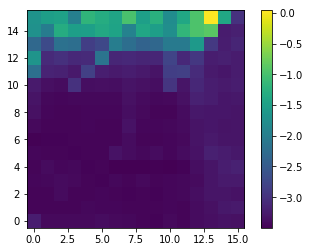

In [12]:
plt.imshow( numpy.log10(runtime_2d / 2048 *numpy.abs((success_2d / 256 - 1))), origin='lower')
plt.colorbar()
plt.show()

In [ ]:
numpy.abs((success_2d / 256 - 1))

Text(0.5,1,'Dengo Performance')

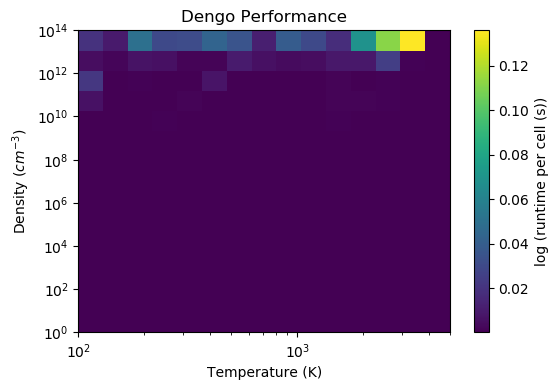

In [14]:
fig,ax = plt.subplots(dpi = 100)
timemap = ax.pcolor(temp_2d, den_2d,numpy.log10(runtime_2d*numpy.abs((success_2d / 256 - 1)) / 2048) )
ax.set_xscale('log')
ax.set_yscale('log')
cbar = plt.colorbar(timemap)
cbar.set_label( 'log (runtime per cell (s))')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Density ($cm^{-3}$)')
ax.set_title("Dengo Performance")

In [11]:
numpy.save( "runtime_dengo2d.npy",runtime_2d)
numpy.save( "success_dengo2d.npy", success_2d)

In [15]:
success_2d

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]])

In [ ]:
temp_list

In [ ]:
result = os.system('./a.out {}'.format(t_ff))

In [ ]:
!bash runfile

In [ ]:
type(result)

In [ ]:
t_ff / 1e10

In [ ]:
!pwd

In [ ]:
all_result 

In [3]:
import numpy

In [75]:
from matplotlib import pyplot
import os
import yt

from pygrackle import \
    FluidContainer, \
    chemistry_data, \
    evolve_constant_density

from pygrackle.utilities.physical_constants import \
    mass_hydrogen_cgs, \
    sec_per_Myr, \
    cm_per_mpc

tiny_number = 1e-20

def run_grackle(density, initial_temperature, final_time):
    current_redshift = 0.

    # Set initial values
#     density             = 0.1 # g /cm^3
#     initial_temperature = 1.e6 # K
#     final_time          = 100.0 # Myr

    # Set solver parameters
    my_chemistry = chemistry_data()
    my_chemistry.use_grackle = 1
    my_chemistry.with_radiative_cooling = 1
    my_chemistry.primordial_chemistry = 2
    my_chemistry.metal_cooling = 0
    my_chemistry.UVbackground = 0
    my_chemistry.three_body_rate = 4
    my_chemistry.self_shielding_method = 0
    my_chemistry.H2_self_shielding = 0
    grackle_dir = "/home/kwoksun2/grackle"
    my_chemistry.grackle_data_file = os.sep.join(
        [grackle_dir, "input", "CloudyData_UVB=HM2012.h5"])

    # Set units
    my_chemistry.comoving_coordinates = 0 # proper units
    my_chemistry.a_units = 1.0
    my_chemistry.a_value = 1. / (1. + current_redshift) / \
        my_chemistry.a_units
    my_chemistry.density_units = mass_hydrogen_cgs # rho = 1.0 is 1.67e-24 g
    my_chemistry.length_units = cm_per_mpc         # 1 Mpc in cm
    my_chemistry.time_units = sec_per_Myr          # 1 Myr in s
    my_chemistry.velocity_units = my_chemistry.a_units * \
        (my_chemistry.length_units / my_chemistry.a_value) / \
        my_chemistry.time_units

    rval = my_chemistry.initialize()

    fc = FluidContainer(my_chemistry, 1)
    # fc.grid_dimension = 2048
    fc["density"][:] = density
    if my_chemistry.primordial_chemistry > 0:
        fc["HI"][:] = 0.76 * fc["density"]
        fc["HII"][:] = tiny_number * fc["density"]
        fc["HeI"][:] = (1.0 - 0.76) * fc["density"]
        fc["HeII"][:] = tiny_number * fc["density"]
        fc["HeIII"][:] = tiny_number * fc["density"]
    if my_chemistry.primordial_chemistry > 1:
        fc["H2I"][:] = tiny_number * fc["density"]
        fc["H2II"][:] = tiny_number * fc["density"]
        fc["HM"][:] = tiny_number * fc["density"]
        fc["de"][:] = tiny_number * fc["density"]
    if my_chemistry.primordial_chemistry > 2:
        fc["DI"][:] = 2.0 * 3.4e-5 * fc["density"]
        fc["DII"][:] = tiny_number * fc["density"]
        fc["HDI"][:] = tiny_number * fc["density"]
    if my_chemistry.metal_cooling == 1:
        fc["metal"][:] = 0.1 * fc["density"] * \
          my_chemistry.SolarMetalFractionByMass

    fc["x-velocity"][:] = 0.0
    fc["y-velocity"][:] = 0.0
    fc["z-velocity"][:] = 0.0

    fc["energy"][:] = initial_temperature / \
        fc.chemistry_data.temperature_units
    fc.calculate_temperature()
    fc["energy"][:] *= initial_temperature / fc["temperature"]

    # timestepping safety factor
    safety_factor = 0.01

    # let gas cool at constant density
    data = evolve_constant_density(
        fc, final_time=final_time,
        safety_factor=safety_factor)
    return data

In [79]:
runtime_grackle = []
all_result_grackle = []
d = 0
for temperature, density in den_temp_pair2d:

    t_ff = ((u.G * u.mass_hydrogen * density * u.cm**-3)**-0.5).in_units('yr')/ 1e6
    
    tic = time.time()
    data = run_grackle(density, temperature, t_ff.v)
    toc = time.time()
    
#     print('{}th strip'.format(d))
#     print( "at T = {}, density = {}, with runtime of {}s".format( temperature, density, (toc-tic)))
    
    runtime_grackle.append(toc-tic)
#     all_result_grackle.append(result)
    d += 1

YTArray([2660.89597829, 2003.13373508, 1983.80804479, 1936.78791015,
         1912.62028045, 1855.25890089, 1775.15842099, 1683.75920066,
         1589.9459724 , 1505.67491821, 1432.77608298, 1372.01690104,
         1319.92683258, 1275.30607242, 1236.77901502, 1202.86895608,
         1172.87561723, 1146.22890522, 1121.99878113, 1100.05151738,
         1080.07410319, 1061.65276337, 1044.61464624, 1028.84391835,
         1014.25152947, 1000.54380463,  987.63307102,  975.50375165,
          964.06176158,  953.22278587,  942.94794864,  933.25572598,
          924.00289703,  915.16386325,  906.68508676,  898.55651349,
          890.75595831,  883.27531471,  876.1011791 ,  869.18508709,
          862.51251223,  856.07845164,  849.87777728,  843.88755487,
          838.07984598,  832.45164769,  826.99986779,  821.72133076,
          816.60314768,  811.62078474,  806.77243437,  802.05622934,
          797.47024335,  793.0124955 ,  788.66935452,  784.42710073,
          780.28464075,  776.24083

AttributeError: 'numpy.ndarray' object has no attribute 'pcolor'

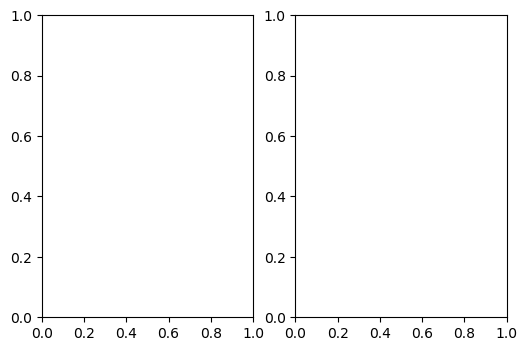

In [51]:
fig,ax = plt.subplots(1,2,dpi = 100)
timemap = ax.pcolor(temp_2d, den_2d,numpy.log10(runtime_2d_grackle/2048 )  )
ax.set_xscale('log')
ax.set_yscale('log')
cbar = plt.colorbar(timemap)
cbar.set_label( 'log (runtime per cell (s))')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Density ($cm^{-3}$)')
ax.set_title("Grackle Performance")

In [42]:
cbar.set_norm()

NameError: name 'temp_2d' is not defined

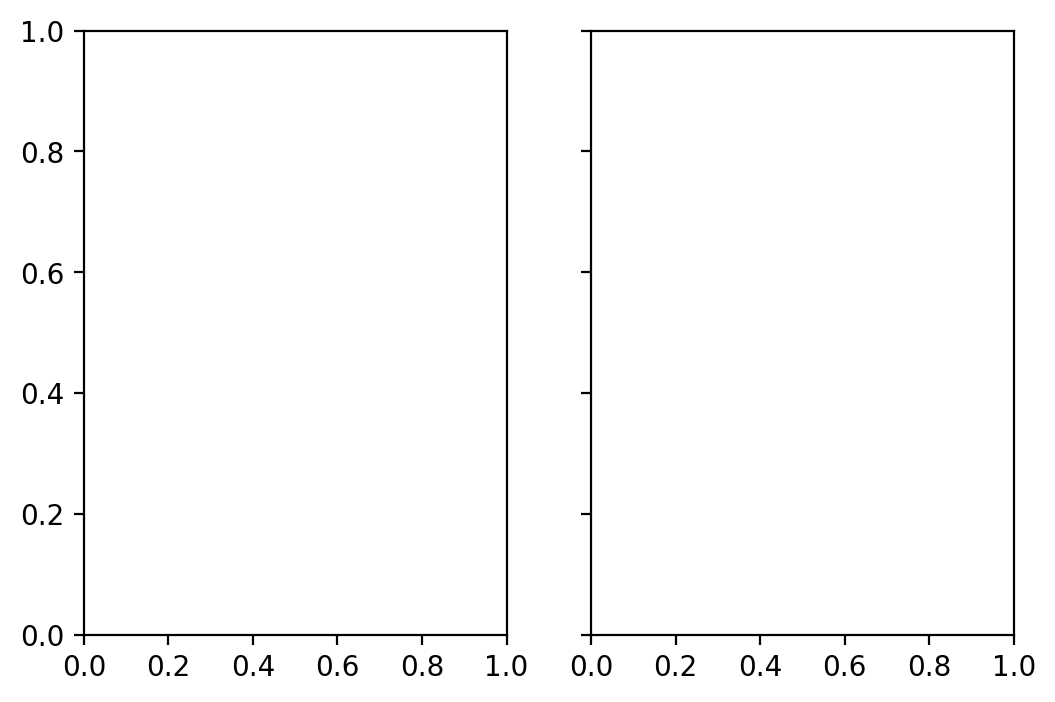

In [13]:
fig,ax = plt.subplots(1,2,dpi=200, sharex=True,sharey=True)
timemap = ax[0].pcolor(temp_2d, den_2d, numpy.log10( (time_taken_dengo ) / 2048  ) , vmin=-5, vmax=0)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
# cbar = plt.colorbar(timemap)

cbar.set_label( 'log (runtime per cell (s))')
ax[0].set_xlabel('Temperature (K)')
ax[0].set_ylabel('Density ($cm^{-3}$)')
ax[0].set_title("Dengo Performance")
ax[0].set_aspect( 1.0/8.235294117647058, 'box' )

timemap = ax[1].pcolor(temp_2d, den_2d, numpy.log10( (grackle_2d ) / 2048  ), vmin=-5, vmax=0 )
ax[1].set_xscale('log')
ax[1].set_yscale('log')
# cbar = plt.colorbar(timemap)
# cbar.set_label( 'log (runtime per cell (s))')
ax[1].set_title("Grackle Performance")
ax[1].set_aspect( 1.0/8.235294117647058, 'box' )



In [ ]:
ax[0].set_aspect

NameError: name 'temp_2d' is not defined

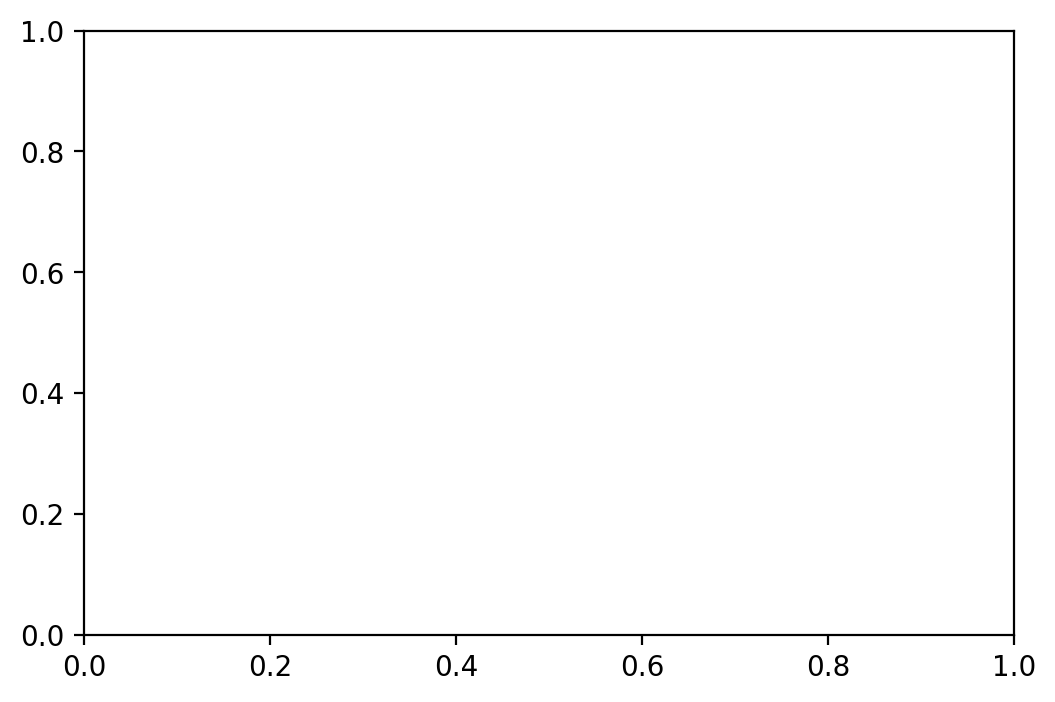

In [14]:
fig,ax = plt.subplots(dpi = 200)
timemap = ax.pcolor(temp_2d, den_2d, numpy.log10( (grackle_2d ) / 2048  ), vmin=-5, vmax=0 )
ax.set_xscale('log')
ax.set_yscale('log')
cbar = plt.colorbar(timemap)
cbar.set_label( 'log (runtime per cell (s))')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Density ($cm^{-3}$)')
ax.set_title("Grackle Performance")

Text(0.5,1,' Dengo runtime vs Grackle runtime')

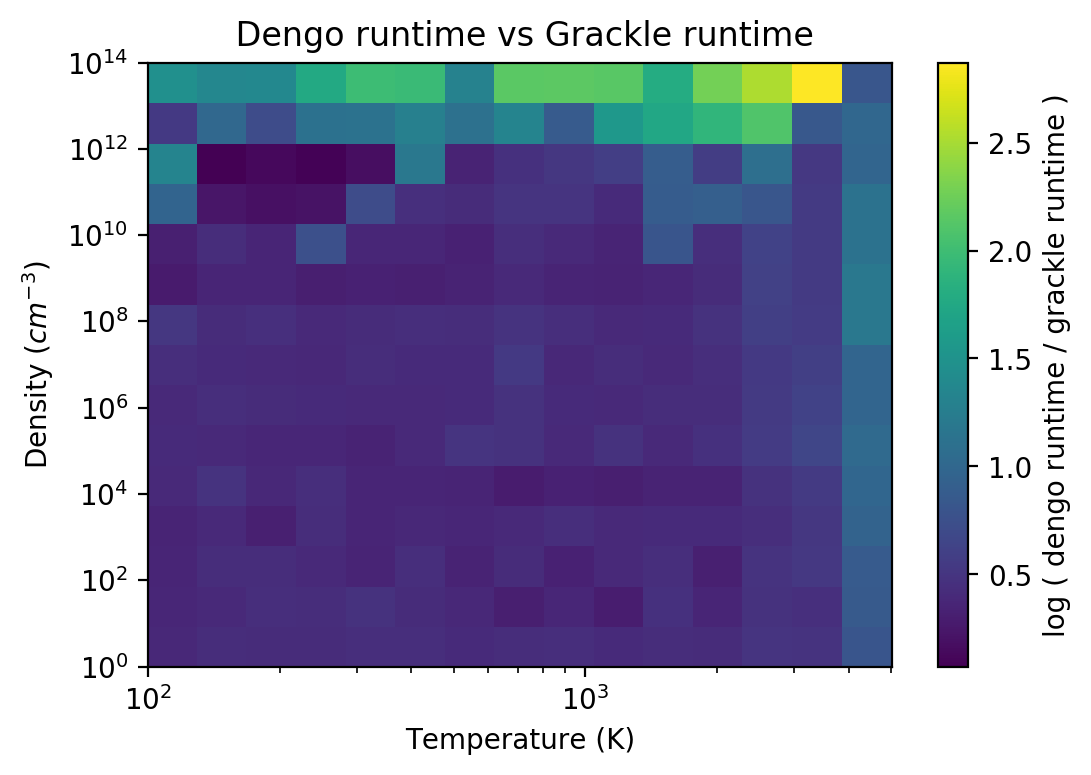

In [179]:
fig,ax = plt.subplots(dpi = 200)
timemap = ax.pcolor(temp_2d, den_2d, numpy.log10( (time_taken_dengo ) / grackle_2d   ) )
ax.set_xscale('log')
ax.set_yscale('log')
cbar = plt.colorbar(timemap)
cbar.set_label( 'log ( dengo runtime / grackle runtime )')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Density ($cm^{-3}$)')
ax.set_title(" Dengo runtime vs Grackle runtime")

Text(0,0.5,' number of cells')

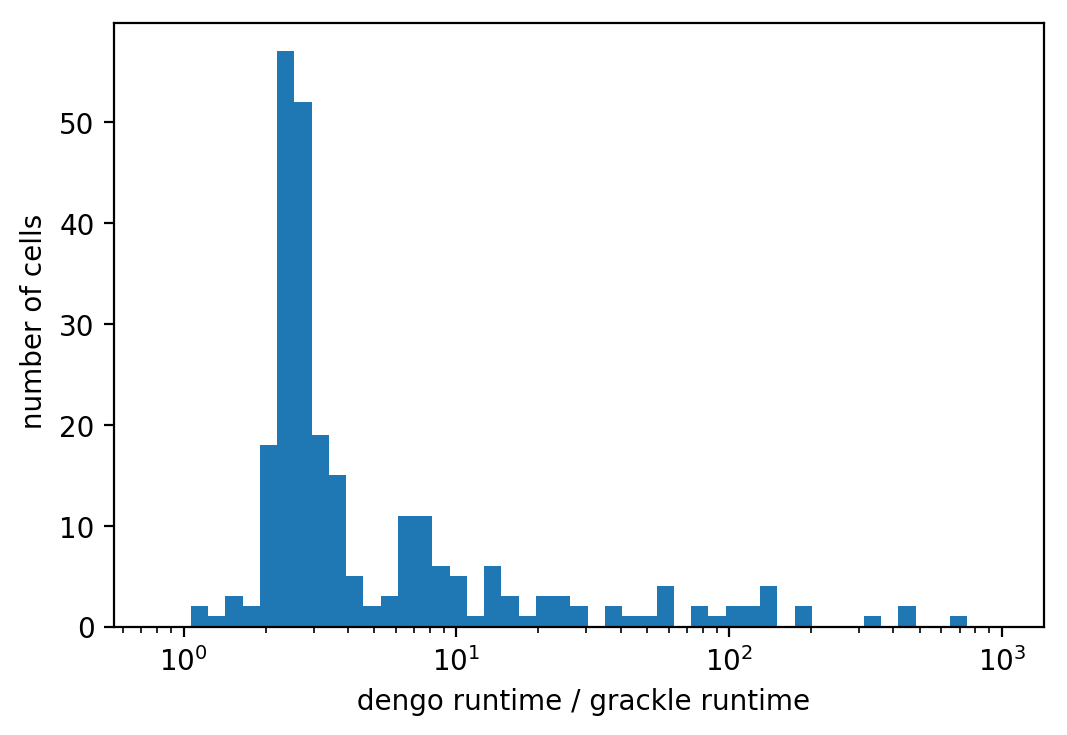

In [172]:
plt.figure(dpi=200)
plt.hist( (time_taken_dengo / grackle_2d).flatten()  , bins=np.logspace( -0.1, 3, 50) )
plt.gca().set_xscale('log')
plt.xlabel(' dengo runtime / grackle runtime')
plt.ylabel(' number of cells')

Text(0,0.5,' number of cells')

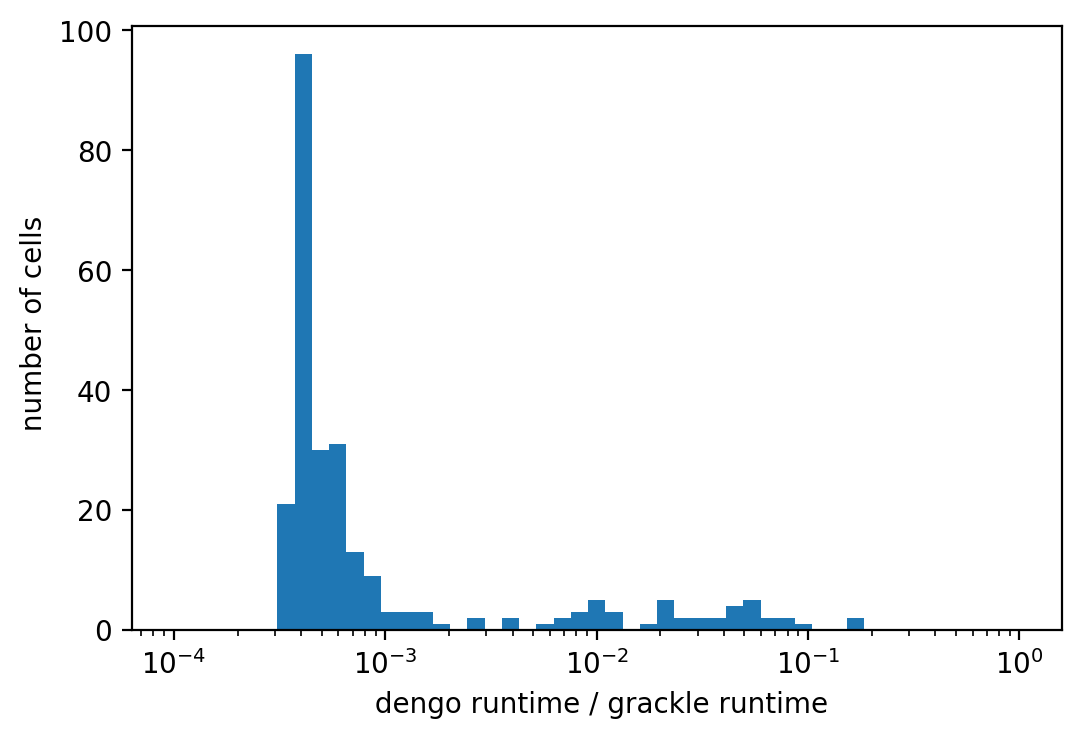

In [17]:
plt.figure(dpi=200)
plt.hist( (time_taken_dengo/2048 ).flatten()  , bins=np.logspace( -4, 0, 50) )
plt.gca().set_xscale('log')
plt.xlabel(' dengo runtime / grackle runtime')
plt.ylabel(' number of cells')

Text(0,0.5,' number of cells')

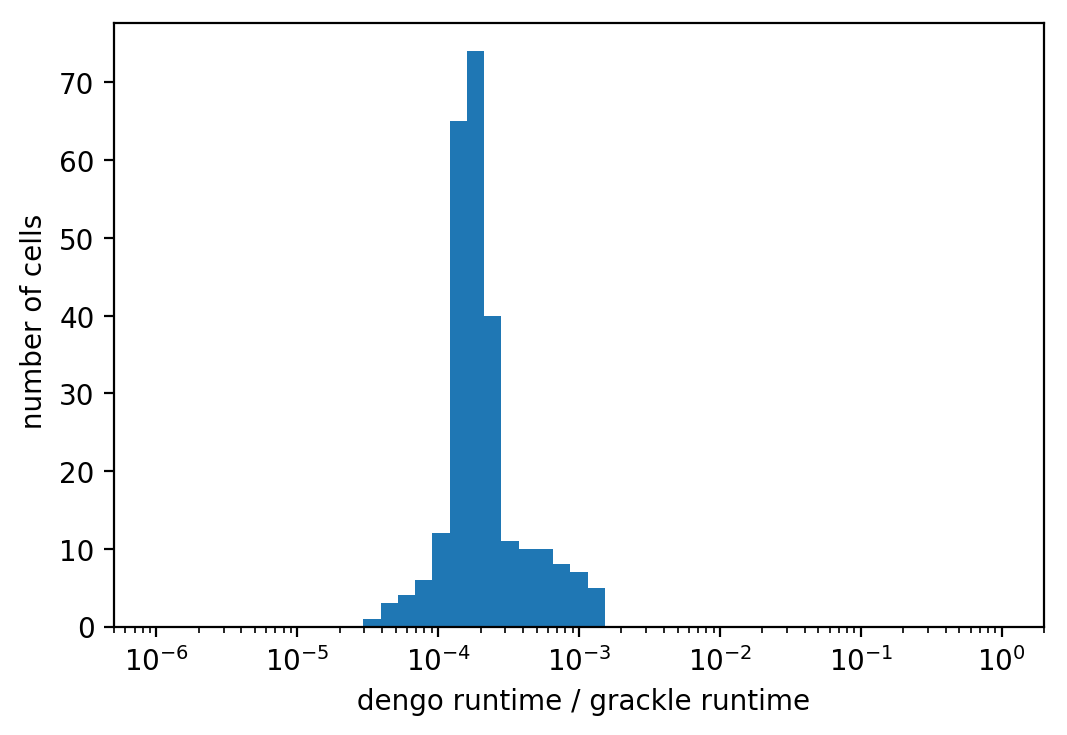

In [16]:
plt.figure(dpi=200)
plt.hist( (grackle_2d/2048 ).flatten()  , bins=np.logspace( -6, 0, 50) )
plt.gca().set_xscale('log')
plt.xlabel(' dengo runtime / grackle runtime')
plt.ylabel(' number of cells')

In [23]:
numpy.logspace(0,1,10)

array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ])

In [24]:
temp_list = numpy.logspace(2,3.7,Tdim)
den_list  = numpy.logspace(0,14,Ddim)

In [25]:
temp_list

array([ 100.        ,  129.8175275 ,  168.52590448,  218.77616239,
        284.00980479,  368.69450645,  478.63009232,  621.34575175,
        806.61569218, 1047.12854805, 1359.35639088, 1764.68285662,
       2290.86765277, 2973.94774523, 3860.70543215, 5011.87233627])

In [26]:
den_list

array([1.00000000e+00, 8.57695899e+00, 7.35642254e+01, 6.30957344e+02,
       5.41169527e+03, 4.64158883e+04, 3.98107171e+05, 3.41454887e+06,
       2.92864456e+07, 2.51188643e+08, 2.15443469e+09, 1.84784980e+10,
       1.58489319e+11, 1.35935639e+12, 1.16591440e+13, 1.00000000e+14])

In [37]:
s = grackle_time.replace('\n', ',')
grackle_runtime2d = numpy.fromstring(s, sep=',')

NameError: name 'grackle_time' is not defined

In [20]:
gra2d = grackle_runtime2d.reshape(16,16)

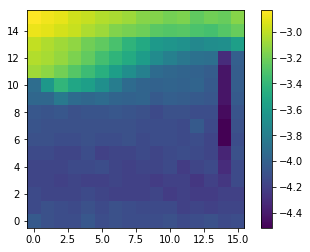

In [150]:
plt.imshow( numpy.log10(grackle_2d/4096) ,origin='lower')
plt.colorbar()

In [39]:
runtime

array([[  1.236727  ,   1.45732903,   1.27865505,   1.16700101,
          1.22687697,   1.34899402,   1.13741302,   1.09336209,
          1.28775811,   1.15903282,   1.29886103,   1.17424393,
          1.20016098,   1.44186878,   1.79626989,   2.06950712],
       [  1.22227883,   1.47770596,   1.2659831 ,   1.1828289 ,
          1.23488903,   1.19738102,   1.13567996,   1.121243  ,
          1.06182098,   1.09687901,   1.20704103,   1.32037592,
          1.25603509,   1.43914199,   1.789675  ,   2.03298092],
       [  1.29304409,   1.23564792,   1.46115589,   1.19288611,
          1.20011592,   1.15625   ,   1.2978971 ,   1.21739888,
          1.06307292,   1.0785749 ,   1.379884  ,   1.19296408,
          1.269104  ,   1.55685902,   1.76585388,   1.96677494],
       [  1.18984604,   1.28231096,   1.19582605,   1.19886494,
          1.18732595,   1.25220799,   1.25331807,   1.06362295,
          1.19381404,   1.12211108,   1.32241607,   1.15746593,
          1.33021808,   1.90556812,  

In [40]:
import h5py

In [41]:
f = h5py.File('test_cvdls_initial_conditions.h5')
f['density'][0]

100000000000000.0

In [42]:
f['T'][0]

5011.872336272725

In [43]:
f.close()

In [45]:
100000000000000.0/1e14

1.0

In [46]:
(1e14* u.cm**-3 * u.G *u.mass_hydrogen)**-0.5

299204917.32712233 s

In [48]:
299204917 / 1e8

2.99204917

In [49]:
t_ff = ((u.G * u.mass_hydrogen * density * u.cm**-3)**-0.5).in_units('s')

In [50]:
print("./a.out {}".format(t_ff))

./a.out 299204917.327


In [54]:
%%time
result = os.system('./a.out {}'.format(t_ff))

CPU times: user 0 ns, sys: 62.5 ms, total: 62.5 ms
Wall time: 2.03 s


In [5]:
time = get_name_from_file()
real_time = []
for t in time:
    _time_ = t.strip("\n").split('\t')[1]
    
    real_time.append( change_time_to_s(_time_) )

len(real_time)

256

In [2]:
def get_name_from_file( name = "real" ):
    f = open('run_test_initial.output', 'r')
    result = list()
    for line in open('run_test_initial.output'):
        line = f.readline()
        if name in line:
            result.append(line)
    f.close()
    return result

In [8]:
dtf_final = get_name_from_file( name = "dtf_final" )
final_time = []
for t in dtf_final:
    final_time_ = t.strip('\n').split(':')[1]
    final_time.append( numpy.float64(final_time_) )
    

def get_tff(density):
    tff0 = 2.99205e15
    tff = tff0 / numpy.sqrt(density)
    return tff
    
t_ff_list = []
for density in den_2d.flatten():
    t_ff = get_tff(density)
    t_ff_list.append(t_ff)

In [138]:

final_time = numpy.array(final_time).reshape((16,16))
t_ff_list = numpy.array(t_ff_list).reshape((16,16))

plt.imshow( t_ff_list / final_time , origin='lower')
plt.colorbar()

ValueError: cannot reshape array of size 227 into shape (16,16)

In [4]:
def change_time_to_s( min_s ):
    minutes, seconds =  min_s.strip('s').split('m')
    minute = float(minutes)
    second = float(seconds)
    
    total_time = minute*60.0 + second
    
    return total_time

In [8]:
time_taken_dengo = numpy.array(real_time).reshape((16,16))

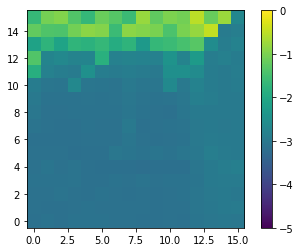

In [9]:
plt.imshow( numpy.log10(time_taken_dengo / 1024) ,origin='lower')
plt.clim(-5, 0)
plt.colorbar()

In [11]:
grackle_timeout = "/home/kwoksun2/grackle/src/example/grackle_runtime.out"

In [12]:
grackle_2d = numpy.loadtxt(grackle_timeout).reshape((16,16))

In [99]:
0.121 @256
0.43 @1024
0.801 @2048

SyntaxError: invalid syntax (<ipython-input-99-a303c5387eea>, line 1)

In [100]:

cells = [256,1024,2048]
time = [0.121,0.43,0.801]


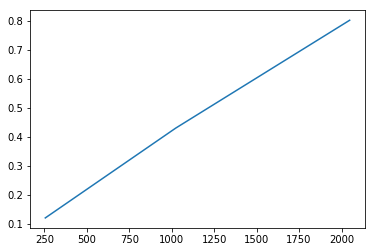

In [144]:
plt.plot(cells, time)

In [105]:
numpy.interp( 0.0, cells, time )

0.121

In [108]:
numpy.polyfit(cells,time, 1)

array([0.00037854, 0.03074324])

In [109]:
cells

[256, 1024, 2048]

In [115]:
0.03074324 / (0.00037854* 2048 )

0.03965590863911344

In [6]:
!ls

100.h5	138.h5	175.h5	211.h5	249.h5	54.h5  91.h5
101.h5	139.h5	176.h5	212.h5	24.h5	55.h5  92.h5
102.h5	13.h5	177.h5	213.h5	250.h5	56.h5  93.h5
103.h5	140.h5	178.h5	214.h5	251.h5	57.h5  94.h5
104.h5	141.h5	179.h5	215.h5	252.h5	58.h5  95.h5
105.h5	142.h5	17.h5	216.h5	253.h5	59.h5  96.h5
106.h5	143.h5	180.h5	217.h5	254.h5	5.h5   97.h5
107.h5	144.h5	181.h5	218.h5	255.h5	60.h5  98.h5
108.h5	145.h5	182.h5	219.h5	256.h5	61.h5  99.h5
109.h5	146.h5	183.h5	21.h5	25.h5	62.h5  9.h5
10.h5	147.h5	184.h5	220.h5	26.h5	63.h5  a.out
110.h5	148.h5	185.h5	221.h5	27.h5	64.h5  initialize_cvode_solver.C
111.h5	149.h5	186.h5	222.h5	28.h5	65.h5  runfile
112.h5	14.h5	187.h5	223.h5	29.h5	66.h5  run_test
113.h5	150.h5	188.h5	224.h5	2.h5	67.h5  run_test_initial.output
114.h5	151.h5	189.h5	225.h5	30.h5	68.h5  run_test.output
115.h5	152.h5	18.h5	226.h5	31.h5	69.h5  runtime_dengo2d.npy
116.h5	153.h5	190.h5	227.h5	32.h5	6.h5   serial_performance_grid.ipynb
117.h5	154.h5	191.h5	228.h5	33.h5	70.h5  success_dengo2d.npy
11

In [15]:
 (67*2) / real_time[-2]

0.739514348785872

In [1]:
import h5py

/home/kwoksun2/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
time_taken_dengo

array([[  0.767,   0.817,   0.764,   0.805,   0.83 ,   0.835,   0.782,
          0.786,   0.747,   0.752,   0.788,   0.764,   0.905,   0.97 ,
          1.019,   0.985],
       [  0.78 ,   0.763,   0.766,   0.788,   0.838,   0.786,   0.788,
          0.781,   0.771,   0.766,   0.779,   0.793,   0.953,   1.011,
          1.186,   1.241],
       [  0.774,   0.789,   0.878,   0.789,   0.761,   0.81 ,   0.783,
          0.739,   0.776,   0.745,   0.798,   0.814,   0.928,   1.091,
          1.156,   1.04 ],
       [  0.809,   0.821,   0.84 ,   0.852,   0.758,   0.765,   0.831,
          0.793,   0.864,   0.793,   0.815,   0.817,   0.902,   1.102,
          1.221,   1.23 ],
       [  0.774,   0.903,   0.792,   0.852,   0.767,   0.724,   0.71 ,
          0.706,   0.687,   0.729,   0.714,   0.719,   0.938,   1.118,
          1.345,   1.449],
       [  0.797,   0.788,   0.791,   0.734,   0.764,   0.748,   1.004,
          0.895,   0.811,   0.913,   0.807,   0.92 ,   1.04 ,   1.414,
          1.2